In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import ast
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy import stats
from scipy.stats import t
import numpy as np
import pandas as pd
from itertools import combinations

In [2]:
#Function version for numbers eks 1 and eks 2


def proportions(D,num_of_groups,num_of_rounds):
    list_of_proportions_groupwise = [[] for _ in range(num_of_groups)]

    for i in range(0, len(D)):
        wait_time = D.iloc[i, 0]
        correct_str = D.iloc[i, 1]
        guess_str   = D.iloc[i, 2]
        
        # Compute success rate
        success_rate = calculate_correct_and_success_rate(correct_str, guess_str)

        list_of_proportions_groupwise[i // num_of_rounds].append(success_rate)
    return list_of_proportions_groupwise

def calculate_correct_and_success_rate(correct_str, guess_str):
    correct_list = re.findall(r"\d+", correct_str)
    guess_list   = re.findall(r"\d+", guess_str)
    n = len(correct_list)
    num_of_correct = sum(g in correct_list for g in guess_list)
    success_rate = num_of_correct / n if n else 0
    return success_rate

In [3]:
#Function version for letter


def letters_proportions(D,num_of_groups,num_of_rounds):
    list_of_proportions_groupwise = [[] for _ in range(num_of_groups)]

    for i in range(0, len(D)):
        wait_time = D.iloc[i, 0]
        correct_str = D.iloc[i, 1]
        guess_str   = D.iloc[i, 2]
        
        # Compute success rate
        success_rate = letters_calculate_correct_and_success_rate(correct_str, guess_str)

        list_of_proportions_groupwise[i // num_of_rounds].append(success_rate)
    return list_of_proportions_groupwise

def letters_calculate_correct_and_success_rate(correct_str, guess_str):
    correct_list = [w.lower() for w in re.findall(r"\w+", correct_str)]
    guess_list   = [w.lower() for w in re.findall(r"\w+", guess_str)]
    n = len(correct_list)

    num_of_correct = sum(g in correct_list for g in guess_list)
    success_rate = num_of_correct / n if n else 0
    return success_rate

In [4]:
def unpack_grouped_data(data):
    y = np.array([val for group in data for val in group])
    treatm = pd.Categorical(
        [i + 1 for i, group in enumerate(data) for _ in group]
    )
    return y, treatm

def make_boxplot(df_anova_form, group_labels=None):
    # Create the boxplot grouped by treatment
    ax = df_anova_form.boxplot(column='y', by='treatm', grid=False)

    # Customize plot
    plt.title('Boxplots by categories')
    plt.suptitle('')  # Remove default subtitle
    plt.xlabel('')    # Optional: remove x-axis label
    plt.ylabel('Success rate')  # Y-axis label

    # Apply custom group names if provided
    if group_labels is not None:
        ax.set_xticklabels(group_labels)

    

In [5]:
def compute_pairwise_CIs(df, alpha=0.05, group_labels=None):
    # Group stats
    group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])

    # Map group labels if provided
    if group_labels:
        label_map = {group: name for group, name in zip(group_stats.index, group_labels)}
    else:
        label_map = {group: group for group in group_stats.index}

    # Calculate MSE from the ANOVA model
    model = smf.ols('y ~ C(treatm)', data=df).fit()
    anova = sm.stats.anova_lm(model)
    MSE = anova.loc['Residual', 'mean_sq']
    df_resid = anova.loc['Residual', 'df']

    # Get t critical value
    t_crit = t.ppf(1 - alpha / 2, df_resid)

    results = []

    # Iterate over all pairwise group combinations
    for (i, row_i), (j, row_j) in combinations(group_stats.iterrows(), 2):
        mean_diff = row_i['mean'] - row_j['mean']
        se = np.sqrt(MSE * (1 / row_i['count'] + 1 / row_j['count']))
        margin = t_crit * se
        ci_low = mean_diff - margin
        ci_high = mean_diff + margin

        results.append({
            'Group 1': label_map[i],
            'Group 2': label_map[j],
            'Mean diff': mean_diff,
            'CI Lower': ci_low,
            'CI Upper': ci_high
        })

    return pd.DataFrame(results)


In [6]:
def group_vs_grand_mean_CIs(df, alpha=0.05,group_labels=None):
    # Compute group and grand means
    group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])
    grand_mean = df['y'].mean()

    # Create mapping from group label to name
    if group_labels:
        label_map = {group: name for group, name in zip(group_stats.index, group_labels)}
    else:
        label_map = {group: group for group in group_stats.index}

    # ANOVA model for MSE
    model = smf.ols('y ~ C(treatm)', data=df).fit()
    anova = sm.stats.anova_lm(model)
    MSE = anova.loc['Residual', 'mean_sq']
    df_resid = anova.loc['Residual', 'df']

    # Critical t-value
    t_crit = t.ppf(1 - alpha / 2, df_resid)

    results = []

    for group, row in group_stats.iterrows():
        mean_diff = row['mean'] - grand_mean
        se = np.sqrt(MSE / row['count'])
        margin = t_crit * se
        ci_low = mean_diff - margin
        ci_high = mean_diff + margin

        results.append({
            'Group': label_map[group],
            'Mean': row['mean'],
            'Diff from Grand Mean': mean_diff,
            'CI Lower': ci_low,
            'CI Upper': ci_high
        })

    return pd.DataFrame(results)


              df    sum_sq   mean_sq          F        PR(>F)
C(treatm)    4.0  0.684511  0.171128  14.357811  9.055397e-10
Residual   133.0  1.585199  0.011919        NaN           NaN


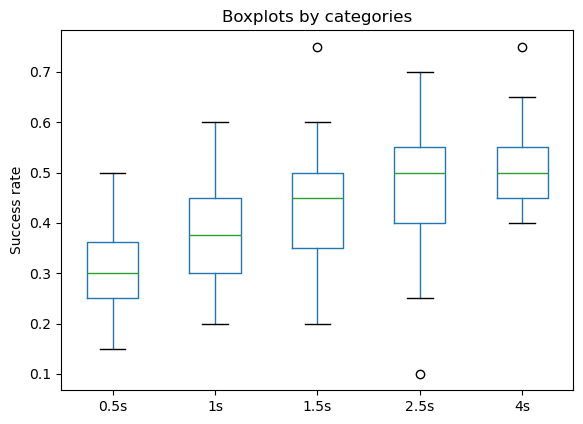

In [7]:
#eksperimetn 1 - ANOVA og boxplot

D1 = pd.read_csv("Ali\eksperiment1.csv")
D2 = pd.read_csv("Carl\eksperiment1.csv")
D3 = pd.read_csv("Erik\eksperiment1.csv")
D4 = pd.read_csv("Kasper\eksperiment1.csv")

D_combined = pd.concat([D1,D2,D3,D4], ignore_index=True)
df_sorted = D_combined.sort_values(by='wait')

# Combine into a DataFrame
df = pd.DataFrame({'y': unpack_grouped_data(proportions(df_sorted,5,28))[0], 'treatm': unpack_grouped_data(proportions(df_sorted,5,28))[1]})

# Fit model
model = smf.ols('y ~ C(treatm)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model)
print(anova_table)
make_boxplot(df,group_labels=['0.5s','1s','1.5s','2.5s','4s'])

In [8]:
#Eks 1 - confidence

compute_pairwise_CIs(df,group_labels=['0.5s','1s','1.5s','2.5s','4s'])

C:\Users\Ali\AppData\Local\Temp\ipykernel_33576\1158369807.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])


,Group 1,Group 2,Mean diff,CI Lower,CI Upper
0,0.5s,1s,-0.058929,-0.116641,-0.001216
1,0.5s,1.5s,-0.119643,-0.177355,-0.061930
2,0.5s,2.5s,-0.155357,-0.213070,-0.097645
3,0.5s,4s,-0.200962,-0.259773,-0.142150
4,1s,1.5s,-0.060714,-0.118427,-0.003002
5,1s,2.5s,-0.096429,-0.154141,-0.038716
6,1s,4s,-0.142033,-0.200845,-0.083221
7,1.5s,2.5s,-0.035714,-0.093427,0.021998
8,1.5s,4s,-0.081319,-0.140131,-0.022507
9,2.5s,4s,-0.045604,-0.104416,0.013207


In [9]:
#Eks 1 - confidence
group_vs_grand_mean_CIs(df,group_labels=['0.5s','1s','1.5s','2.5s','4s'])

C:\Users\Ali\AppData\Local\Temp\ipykernel_33576\2430169284.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])


,Group,Mean,Diff from Grand Mean,CI Lower,CI Upper
0,0.5s,0.312500,-0.105616,-0.146425,-0.064807
1,1s,0.371429,-0.046687,-0.087496,-0.005878
2,1.5s,0.432143,0.014027,-0.026782,0.054836
3,2.5s,0.467857,0.049741,0.008932,0.090550
4,4s,0.513462,0.095346,0.052996,0.137695


In [10]:
#eksperiment 2

# Load the two CSV files
df1 = pd.read_csv('Carl\eksperiment2_WorkingMemoryFalse.csv') 
df2 = pd.read_csv('Ali\eksperiment2_WorkingMemoryFalse.csv') 
df3 = pd.read_csv('Erik\eksperiment2_WorkingMemoryFalse.csv') 
df7 = pd.read_csv('Kasper\eksperiment2_WorkingMemoryFalse.csv') 

df4 = pd.read_csv('Carl\eksperiment2_WorkingMemoryTrue.csv')
df5 = pd.read_csv('Ali\eksperiment2_WorkingMemoryTrue.csv')
df6 = pd.read_csv('Erik\eksperiment2_WorkingMemoryTrue.csv')
df8 = pd.read_csv('Kasper\eksperiment2_WorkingMemoryTrue.csv') 

# Concatenate the DataFrames
work_false_df = pd.concat([df1, df2,df3,df7], ignore_index=True)
work_true_df = pd.concat([df4,df5,df6,df8], ignore_index=True)

work_false = proportions(work_false_df,1,70)
work_false = work_false[0]
work_true = proportions(work_true_df,1,70)
work_true = work_true[0]

#Means
print(np.mean(work_false),np.mean(work_true))

# Paired t-test
t_stat, p_val = ttest_rel(work_false, work_true)

print(f'T-statistic: {t_stat:.4f}, p-value: {p_val}')

#Confidence
stats.ttest_rel(work_false, work_true).confidence_interval(0.95)


0.3607142857142857 0.27071428571428574
T-statistic: 5.3576, p-value: 1.051120563996224e-06


ConfidenceInterval(low=np.float64(0.0564876116777752), high=np.float64(0.12351238832222483))

In [11]:
# eksperimetn 3

D1 = pd.read_csv("Carl\eksperiment3.csv")
D2 = pd.read_csv("Ali\eksperiment3.csv")
D3 = pd.read_csv("Erik\eksperiment3.csv")
D4= pd.read_csv("Kasper\eksperiment3.csv")

D = pd.concat([D1,D2,D3,D4], ignore_index=True)

# Convert string in column 1 to actual Python list and compute its length
D['length'] = D['correctSequence'].str.count("'") // 2

# Sort by length
df_sorted = D.sort_values(by='length')

# Drop the length column if you don’t want it in final result
df_sorted = df_sorted.drop(columns='length')

D = df_sorted

# Combine into a DataFrame
df = pd.DataFrame({'y': unpack_grouped_data(letters_proportions(D,8,21))[0], 'treatm': unpack_grouped_data(letters_proportions(D,8,21))[1]})

# Fit model
model = smf.ols('y ~ C(treatm)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model)
print(anova_table)
make_boxplot(df,group_labels=['3','4','5','6','7','8','9','10'])


IndexError: list index out of range

In [ ]:
compute_pairwise_CIs(df,group_labels=['3','4','5','6','7','8','9','10'])

C:\Users\CvcCl\AppData\Local\Temp\ipykernel_31836\1158369807.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])


,Group 1,Group 2,Mean diff,CI Lower,CI Upper
0,3,4,0.000000,-0.037900,0.037900
1,3,5,0.000000,-0.037900,0.037900
2,3,6,0.000000,-0.037900,0.037900
3,3,7,0.013605,-0.024294,0.051505
4,3,8,0.035714,-0.002185,0.073614
5,3,9,0.026455,-0.011445,0.064355
6,3,10,0.076190,0.038291,0.114090
7,4,5,0.000000,-0.037900,0.037900
8,4,6,0.000000,-0.037900,0.037900
9,4,7,0.013605,-0.024294,0.051505


In [ ]:
group_vs_grand_mean_CIs(df,group_labels=['3','4','5','6','7','8','9','10'])

C:\Users\CvcCl\AppData\Local\Temp\ipykernel_31836\2430169284.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])


,Group,Mean,Diff from Grand Mean,CI Lower,CI Upper
0,3,1.000000,0.018996,-0.007803,0.045795
1,4,1.000000,0.018996,-0.007803,0.045795
2,5,1.000000,0.018996,-0.007803,0.045795
3,6,1.000000,0.018996,-0.007803,0.045795
4,7,0.986395,0.005390,-0.021409,0.032189
5,8,0.964286,-0.016719,-0.043518,0.010080
6,9,0.973545,-0.007459,-0.034258,0.019340
7,10,0.923810,-0.057195,-0.083994,-0.030396


In [ ]:
# eksperimetn 4

df1 = pd.read_csv("Carl\eksperiment4.csv")
df2 = pd.read_csv("Ali\eksperiment4.csv")
df3 = pd.read_csv("Erik\eksperiment4.csv")
df4 = pd.read_csv("Kasper\eksperiment4.csv")

df5 = pd.read_csv("Carl\eksperiment4_chunking.csv")
df6 = pd.read_csv("Ali\eksperiment4_chunking.csv")
df7 = pd.read_csv("Erik\eksperiment4_chunking.csv")
df8 = pd.read_csv("Kasper\eksperiment4_chunking.csv")

# Concatenate the DataFrames
finger_df = pd.concat([df1, df2,df3,df4], ignore_index=True)
lalala_df = pd.concat([df5,df6,df7,df8], ignore_index=True)

finger = letters_proportions(finger_df,1,70)
finger = finger[0]
lalala = letters_proportions(lalala_df,1,70)
lalala = lalala[0]

#Means
print(np.mean(finger),np.mean(lalala))

# Paired t-test
t_stat, p_val = ttest_rel(finger, lalala)

print(f'T-statistic: {t_stat:.4f}, p-value: {p_val:.4f}')

#Confidence
stats.ttest_rel(finger, lalala).confidence_interval(0.95)


In [ ]:
#eksperiment 5

df1 = pd.read_csv("Carl\eksperiment5_finger.csv")
df2 = pd.read_csv("Ali\eksperiment5_finger.csv")
df3 = pd.read_csv("Erik\eksperiment5_finger.csv")
df4 = pd.read_csv("Kasper\eksperiment5_finger.csv")

df5 = pd.read_csv("Carl\eksperiment5_lalala.csv")
df6 = pd.read_csv("Ali\eksperiment5_lalala.csv")
df7 = pd.read_csv("Erik\eksperiment5_lalala.csv")
df8 = pd.read_csv("Kasper\eksperiment5_lalala.csv")

# Concatenate the DataFrames
finger_df = pd.concat([df1, df2,df3,df4], ignore_index=True)
lalala_df = pd.concat([df5,df6,df7,df8], ignore_index=True)

finger = letters_proportions(finger_df,1,70)
finger = finger[0]
lalala = letters_proportions(lalala_df,1,70)
lalala = lalala[0]

#Means
print(np.mean(finger),np.mean(lalala))

# Paired t-test
t_stat, p_val = ttest_rel(finger, lalala)

print(f'T-statistic: {t_stat:.4f}, p-value: {p_val:.4f}')

#Confidence
stats.ttest_rel(finger, lalala).confidence_interval(0.95)


0.9625 0.9071428571428571
T-statistic: 3.3330, p-value: 0.0014


ConfidenceInterval(low=0.022223496373788086, high=0.08849078934049762)